In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

RANDOM_STATE = 42

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
pd.set_option("display.max_columns", None)


In [32]:
# Part 1 – Load data

df = pd.read_csv(r"C:\Users\kafsh\OneDrive\Desktop\hw\data mining\Final Project\Telco_Customer_Churn.csv")

print("Shape:", df.shape)
display(df.head())

print("\nInfo:")
print(df.info())

print("\nChurn distribution:")
print(df["Churn"].value_counts())
print("\nChurn proportion:")
print(df["Churn"].value_counts(normalize=True) * 100)


Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   o

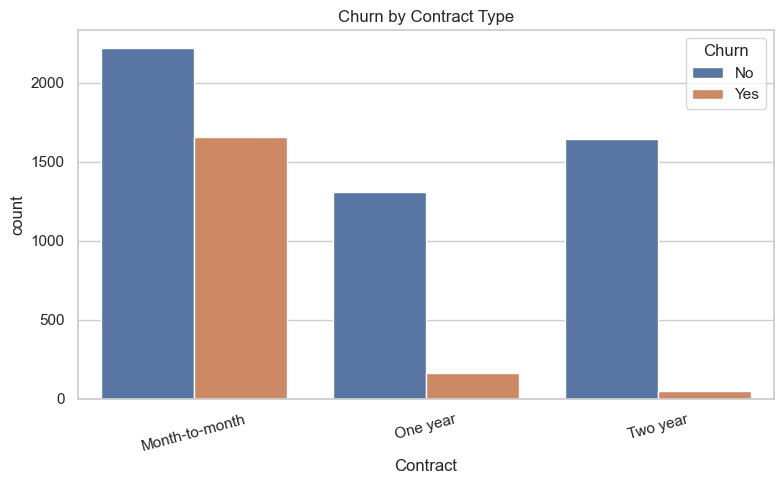

In [36]:
plt.figure()
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Churn by Contract Type")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


C:\Users\kafsh\AppData\Local\Temp\ipykernel_1700\1975051961.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Churn")


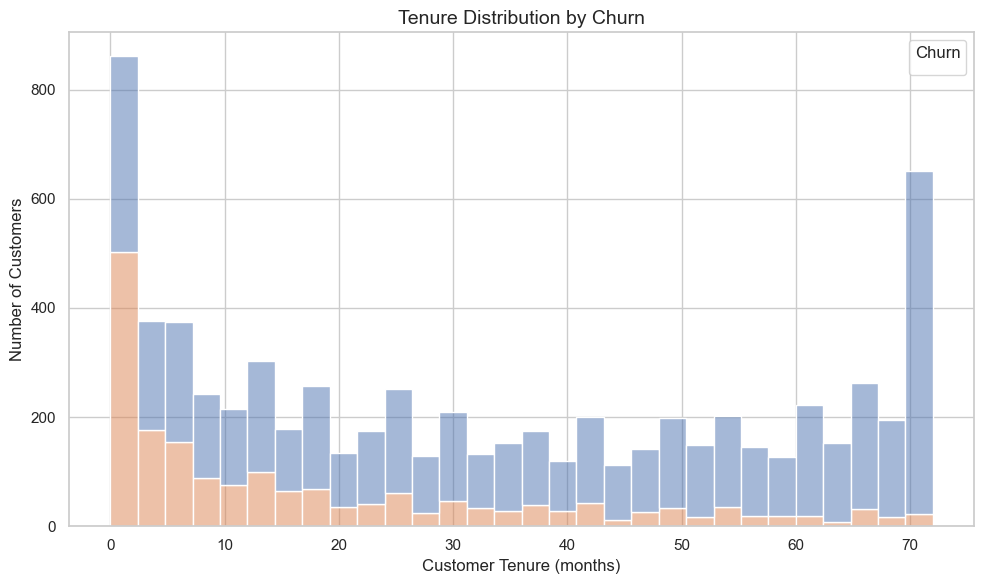

In [54]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df,
    x="tenure",
    hue="Churn",
    bins=30,
    multiple="stack",
    alpha=0.5,
    common_norm=False    # <-- THIS fixes the legend issue
)

plt.title("Tenure Distribution by Churn", fontsize=14)
plt.xlabel("Customer Tenure (months)")
plt.ylabel("Number of Customers")
plt.legend(title="Churn")
plt.tight_layout()
plt.show()


In [19]:
# Part 3 – Clean TotalCharges and handle missing values

df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)
df["TotalCharges"] = df["TotalCharges"].astype(float)

print("Missing values per column:")
print(df.isna().sum())

# Drop rows with missing TotalCharges (only a small number of rows)
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

print("\nShape after dropping missing TotalCharges:", df.shape)


Missing values per column:
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Shape after dropping missing TotalCharges: (7032, 21)


In [20]:
# Feature engineering: tenure_group and numeric target

bins = [0, 12, 24, 48, 60, np.inf]
labels = ["0-12", "13-24", "25-48", "49-60", "60+"]

df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

df["ChurnFlag"] = df["Churn"].map({"No": 0, "Yes": 1})

df[["tenure", "tenure_group", "Churn", "ChurnFlag"]].head()


,tenure,tenure_group,Churn,ChurnFlag
0,1,0-12,No,0
1,34,25-48,No,0
2,2,0-12,Yes,1
3,45,25-48,No,0
4,2,0-12,Yes,1


In [21]:
# Part 4 – Train/Test split

# Drop ID and original text target from features
X = df.drop(columns=["customerID", "Churn", "ChurnFlag"])
y = df["ChurnFlag"]

numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']

Train shape: (5625, 20)
Test shape: (1407, 20)


In [22]:
# Part 4 – Train/Test split

# Drop ID and original text target from features
X = df.drop(columns=["customerID", "Churn", "ChurnFlag"])
y = df["ChurnFlag"]

numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges", "TotalCharges"]
categorical_features = [col for col in X.columns if col not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("\nTrain shape:", X_train.shape)
print("Test shape:", X_test.shape)


Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']

Train shape: (5625, 20)
Test shape: (1407, 20)


In [23]:
# Preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)


In [26]:
# Part 5 – Define models

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        class_weight="balanced",
        random_state=RANDOM_STATE
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        random_state=RANDOM_STATE
    ),
}

results = []



Training model: Logistic Regression
Accuracy:  0.7235
Precision: 0.4876
Recall:    0.7914
F1-score:  0.6035
ROC-AUC:   0.8344

Confusion matrix:
[[722 311]
 [ 78 296]]


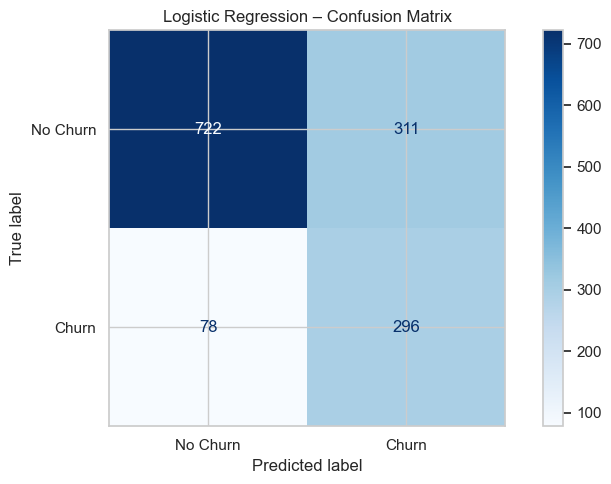


Training model: Random Forest
Accuracy:  0.7854
Precision: 0.6241
Recall:    0.4840
F1-score:  0.5452
ROC-AUC:   0.8173

Confusion matrix:
[[924 109]
 [193 181]]


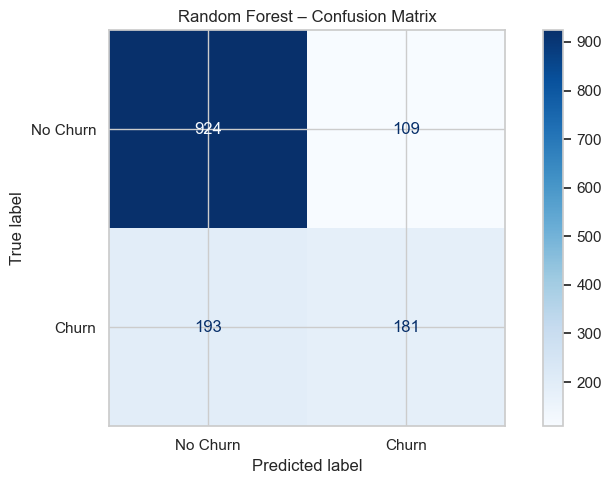


Training model: Gradient Boosting
Accuracy:  0.7960
Precision: 0.6408
Recall:    0.5294
F1-score:  0.5798
ROC-AUC:   0.8383

Confusion matrix:
[[922 111]
 [176 198]]


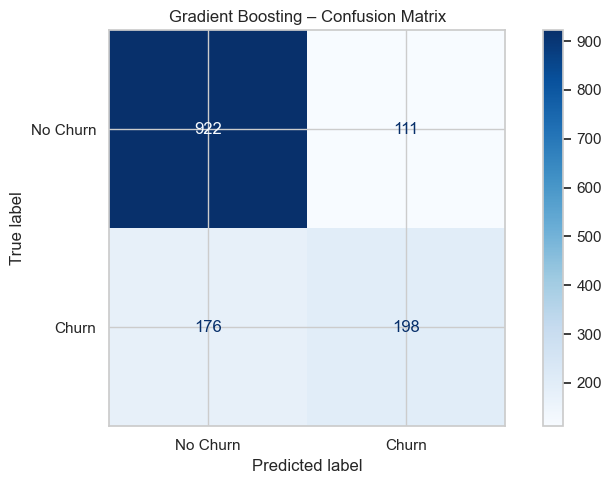

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
2,Gradient Boosting,0.796020,0.640777,0.529412,0.579795,0.838262
0,Logistic Regression,0.723525,0.487644,0.791444,0.603466,0.834402
1,Random Forest,0.785359,0.624138,0.483957,0.545181,0.817310


In [27]:
# Train, predict, and evaluate each model

for name, clf in models.items():
    print("\n" + "="*60)
    print(f"Training model: {name}")
    print("="*60)
    
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", clf),
    ])
    
    pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix:")
    print(cm)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} – Confusion Matrix")
    plt.tight_layout()
    plt.show()
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "ROC_AUC": roc,
        "Pipeline": pipe,
    })

# Put metrics into a DataFrame to compare
results_df = pd.DataFrame(results).drop(columns=["Pipeline"])
display(results_df.sort_values(by="ROC_AUC", ascending=False))


<Figure size 800x500 with 0 Axes>

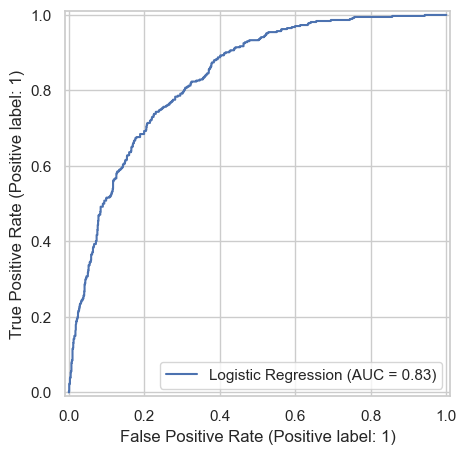

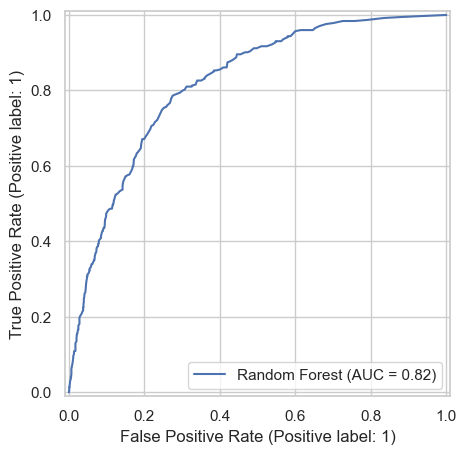

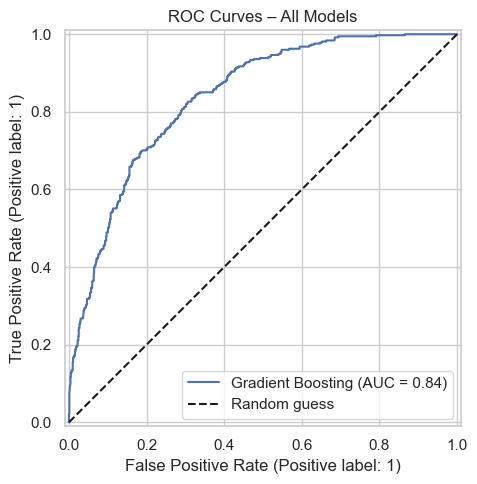

In [28]:
# Part 6 – Plot ROC curves for all models

plt.figure()

for r in results:
    name = r["Model"]
    pipe = r["Pipeline"]
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name)

plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.title("ROC Curves – All Models")
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
# Part 7 – Identify best model by ROC-AUC

best_row = max(results, key=lambda x: x["ROC_AUC"])
best_model_name = best_row["Model"]
best_pipe = best_row["Pipeline"]

print(f"Best model by ROC-AUC: {best_model_name}")


Best model by ROC-AUC: Gradient Boosting



Top 15 features by feature_importances_ for Gradient Boosting:


,feature,importance
36,Contract_Month-to-month,0.393133
1,tenure,0.128671
3,TotalCharges,0.103675
2,MonthlyCharges,0.079233
16,InternetService_Fiber optic,0.077607
18,OnlineSecurity_No,0.071189
27,TechSupport_No,0.039072
43,PaymentMethod_Electronic check,0.035875
21,OnlineBackup_No,0.009895
12,MultipleLines_No,0.009499


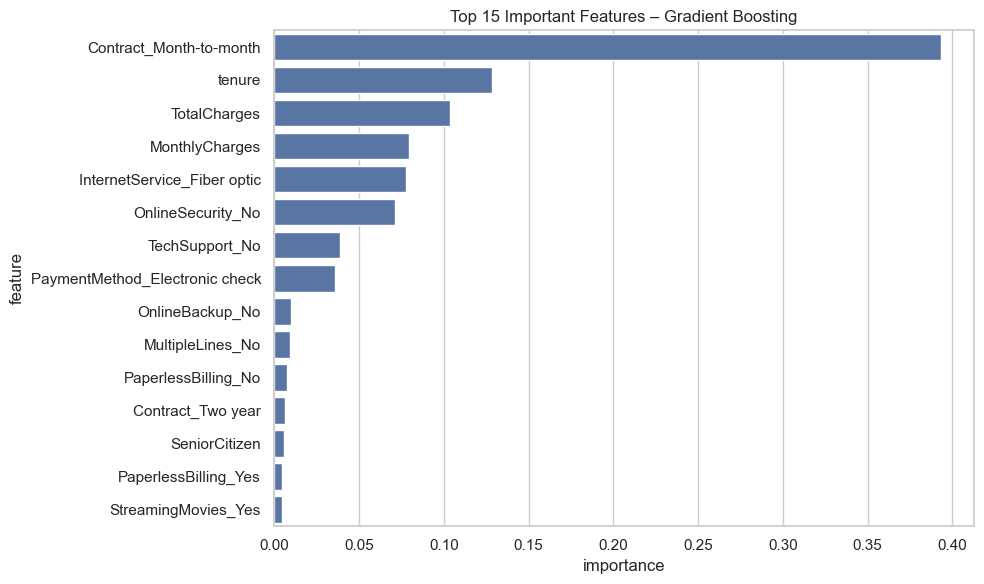

In [30]:
# Get feature names after one-hot encoding

ohe = best_pipe.named_steps["preprocess"].named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))
all_feature_names = numeric_features + cat_feature_names

model_step = best_pipe.named_steps["model"]

importances = None
importance_type = None

if hasattr(model_step, "feature_importances_"):
    importances = model_step.feature_importances_
    importance_type = "feature_importances_"
elif hasattr(model_step, "coef_"):
    coef = model_step.coef_[0]
    importances = np.abs(coef)
    importance_type = "|coefficients|"

if importances is not None:
    feature_importance = pd.DataFrame({
        "feature": all_feature_names,
        "importance": importances,
    }).sort_values(by="importance", ascending=False)
    
    print(f"\nTop 15 features by {importance_type} for {best_model_name}:")
    display(feature_importance.head(15))
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=feature_importance.head(15),
        x="importance",
        y="feature"
    )
    plt.title(f"Top 15 Important Features – {best_model_name}")
    plt.tight_layout()
    plt.show()
else:
    print("Best model does not expose feature_importances_ or coef_.")
